# Tarea 1

En este Jupyter Notebook, incluimos una simulación de reconstrucción de imágenes dada su transformada de Radon.

* Curso: Problemas Inversos y de Control de EDP (MA5306)
* Profesor de Cátedra: Axel Osses A.
* Profesor Auxiliar: Jorge Aguayo
* Estudiante: Johnny Godoy

# Setup

Imports

In [1]:
import platform
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import skimage.transform
import tabulate

from perlin_numpy import generate_perlin_noise_2d

Configuraciones

In [2]:
print(f"\n{tabulate.tabulate(platform.uname()._asdict().items())}")

plt.style.use('ggplot')
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})


-------  ----------
system   Windows
node     GOEDEL
release  10
version  10.0.19044
machine  AMD64
-------  ----------


Constantes

In [3]:
TAMAÑO_IMAGEN = 16
ANGULOS_DE_RAYOS = np.arange(0, 210, 30)

Función de utilidad

In [4]:
def ver_imagen(arreglo_imagen: np.ndarray,
               titulo: str,
               etiqueta_x: str = "$x$",
               etiqueta_y: str = "$y$",
               extent: list = None):
    plt.imshow(arreglo_imagen, origin="lower", extent=extent, aspect='auto')
    plt.colorbar()
    plt.title(titulo)
    plt.xlabel(etiqueta_x)
    plt.ylabel(etiqueta_y)
    plt.grid()

# Simulando datos de una tomografía

Generaremos un arreglo de densidades a través de ruido de Perlin 2D. Este arreglo será considerado desconocido, y es lo que queremos encontrar.

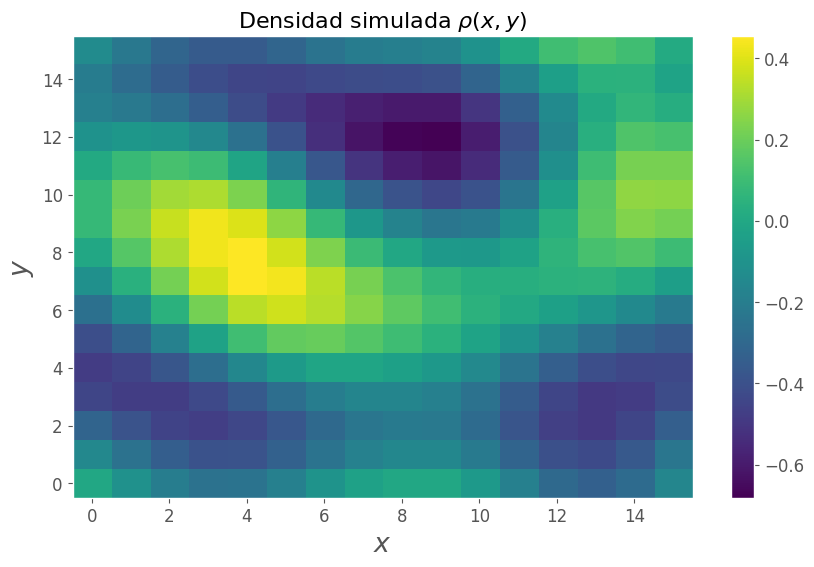

In [5]:
densidades_simuladas = generate_perlin_noise_2d((TAMAÑO_IMAGEN, TAMAÑO_IMAGEN), (2, 2))
ver_imagen(densidades_simuladas, r"Densidad simulada $\rho(x, y)$")

# Calculando la transformada

Esto se logra con `skimage.transform.radon`. Consideramos este arreglo como el cual realmente podemos medir:

C:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


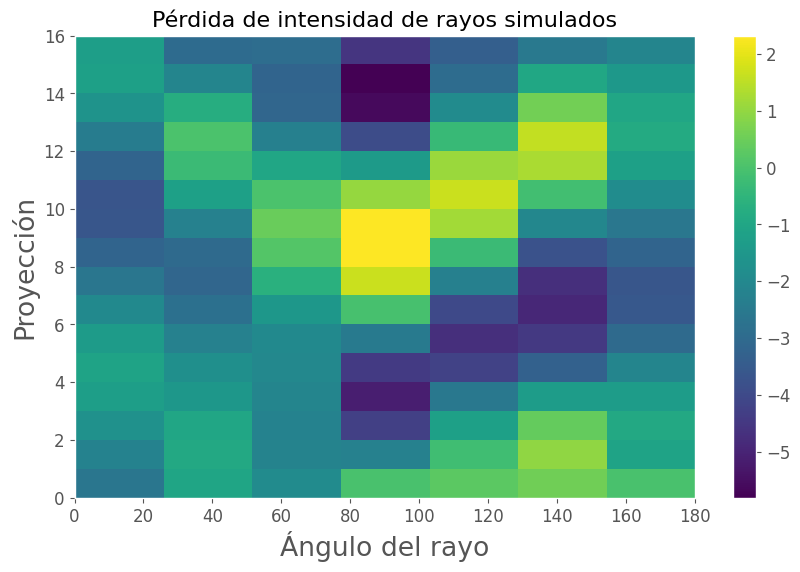

In [6]:
transformada_simulada = skimage.transform.radon(densidades_simuladas,
                                                theta=ANGULOS_DE_RAYOS)
ver_imagen(transformada_simulada, "Pérdida de intensidad de rayos simulados",
           "Ángulo del rayo", "Proyección", extent=[0, 180, 0, 16])
plt.xticks = ANGULOS_DE_RAYOS

# Modelo de optimización

Dado $\tilde{R}$ la transformada de Radon medida, podemos encontrar la densidad resolviendo el siguiente problema de optimización:

$$
\min_{\rho\in \mathbb{R}^{16\times 16}} \Vert R(\rho) - \tilde{R} \Vert 
$$

In [7]:
def costo(densidad_cantidata):
    como_imagen = densidad_cantidata.reshape(TAMAÑO_IMAGEN, TAMAÑO_IMAGEN)
    transformada_candidata = skimage.transform.radon(como_imagen, theta=ANGULOS_DE_RAYOS)
    error = transformada_candidata - transformada_simulada
    return (error*error).mean()

Suponemos que si bien no tenemos acceso a las densidades, sí lo tenemos a su promedio.

Así, construimos un punto inicial para la optimización como una imagen constante con valor igual a esta densidad promedio en todo punto.

In [8]:
densidades_iniciales = densidades_simuladas.mean()*np.ones_like(densidades_simuladas).flatten()
solucion = scipy.optimize.minimize(fun=costo, x0=densidades_iniciales)
solucion

      fun: 1.67669891479261e-07
 hess_inv: array([[ 7.60282762e+02, -3.75646114e+01, -1.43891741e+01, ...,
         6.05326789e+01,  5.74792500e+00, -4.47663312e+01],
       [-3.75646114e+01,  5.62812810e+01,  8.40379694e-01, ...,
        -9.48234812e+00,  6.94437713e-01,  5.34413005e+00],
       [-1.43891741e+01,  8.40379694e-01,  1.51356578e+01, ...,
        -1.37278836e+01, -8.19517768e+00, -5.75070529e-01],
       ...,
       [ 6.05326789e+01, -9.48234812e+00, -1.37278836e+01, ...,
         3.25952950e+01,  1.03393255e+01, -9.33674785e+00],
       [ 5.74792500e+00,  6.94437713e-01, -8.19517768e+00, ...,
         1.03393255e+01,  9.13561452e+00,  1.16619574e+00],
       [-4.47663312e+01,  5.34413005e+00, -5.75070529e-01, ...,
        -9.33674785e+00,  1.16619574e+00,  1.21852659e+01]])
      jac: array([-1.74568100e-06, -7.16395844e-06,  4.77339888e-06,  8.43442086e-07,
        2.45821716e-06, -2.52557353e-07, -8.48157311e-07,  5.10044261e-06,
        2.76735759e-06,  2.83819128e-06

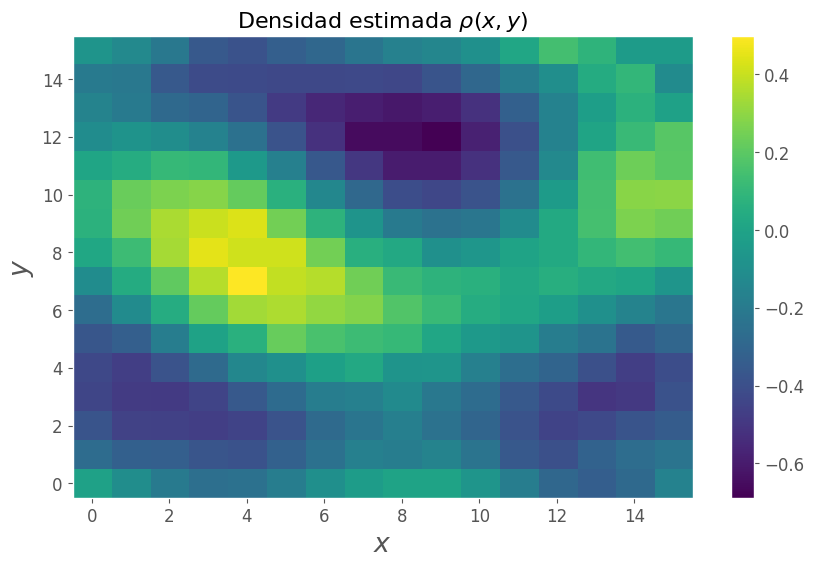

In [9]:
densidades_estimadas = solucion.x.reshape(TAMAÑO_IMAGEN, TAMAÑO_IMAGEN)
ver_imagen(densidades_estimadas, r"Densidad estimada $\rho(x, y)$")

In [11]:
error = densidades_estimadas - densidades_simuladas
print(f"Error en la densidad: {(error*error).mean()}")

Error en la densidad: 0.0008855905137530617


La solución es casi idéntica a lo que buscamos reconstruir, con un error de `1e-07` en las transformadas, y un error de `8e-04` en la imagen original.

Así, se puede reconstruir la imagen (i.e., resolver el problema inverso) con un método simple de optimización, asumiendo que tenemos acceso a una función que calcule la transformada de Radon (i.e., que resuelve el problema directo). 

En la práctica esto no es problema, pues calcular la transformada de Radon solamente requiere integrales a lo largo de un rayo.

Cabe destacar que si bien el supuesto usual es que proveemos de la transformada de Radon completa (es decir, su evaluación para cualquier recta), la reconstrucción solamente requirió utilizar 7 rectas.

Sin embargo, puede ser más desafiente escalar esta metodología para imágenes más grandes, pues una de $16\times16$ ya requirió $20$ segundos para resolver.
